# Setup: Generate Sample Dataset

This cell creates the required folder structure (`data/raw/` and `data/processed/`) relative to the notebook, and generates the sample CSV dataset with missing values. 
This ensures the dataset is ready for cleaning functions and saves it to `data/raw/outliers_homework.csv`.

In [68]:
import os
import numpy as np
import pandas as pd

# Define folder paths relative to this notebook
raw_dir = '../data/raw'
processed_dir = '../data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

File already exists at ../data/raw\outliers_homework.csv. Skipping CSV creation to avoid overwrite.


# Stage 7 Homework — Outliers + Risk Assumptions
In this assignment you will implement outlier detection/handling and run a simple sensitivity analysis.

**Chain:** In the lecture, we learned detection (IQR, Z-score), options for handling (remove/winsorize), and sensitivity testing. Now, you will adapt those methods to a provided dataset and document the risks and assumptions behind your choices.

In [69]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(17)

## Load Data (provided or synthetic fallback)

In [70]:
data_path = Path('data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0.000000,1.331519
1,0.050251,-1.115001
2,0.100503,1.969787
3,0.150754,2.706032
4,0.201005,2.686840


## TODO: Implement Outlier Functions (required)

In [71]:
import pandas as pd

def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    q1 = series.quantile(0.25)       
    q3 = series.quantile(0.75)       
    iqr = q3 - q1                    
    lower = q1 - k * iqr             
    upper = q3 + k * iqr             
    return (series < lower) | (series > upper)


def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    mu = series.mean()                    
    sigma = series.std(ddof=0)             
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold


*(Stretch)* Implement winsorizing (optional).

In [72]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

## Apply Detection and Create Flags (choose a numeric column)


In [73]:
target_col = 'y' if 'y' in df.columns else df.select_dtypes(include=['number']).columns[0]
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)
df[['outlier_iqr', 'outlier_z']].mean()  # fraction flagged

outlier_iqr    0.005
outlier_z      0.005
dtype: float64

### Visual Checks (boxplot / histogram)

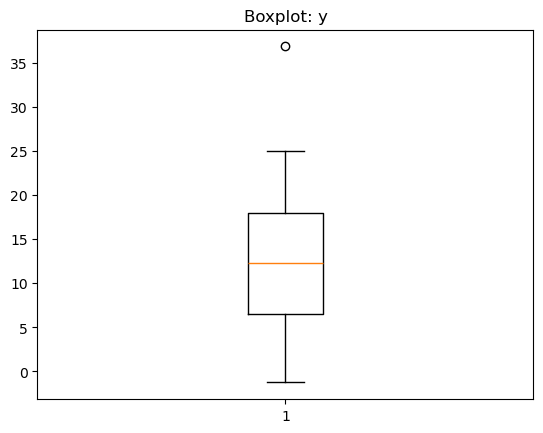

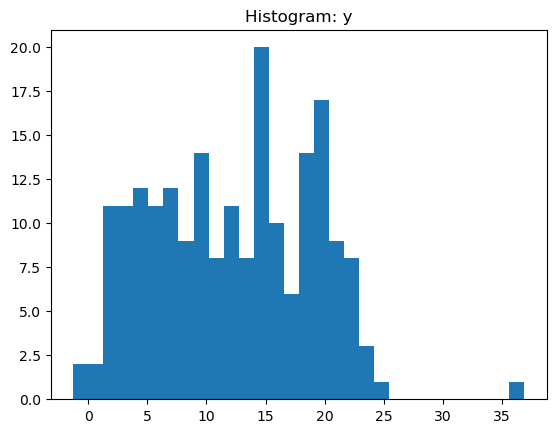

In [74]:
plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

## Sensitivity Analysis
Pick one: summary stats or simple linear regression comparing **all vs. filtered** (and optional winsorized).

In [75]:
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = None
if 'winsorize_series' in globals():
    w = winsorize_series(df[target_col])
    summ_w = w.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        **({'winsorized': summ_w} if summ_w is not None else {})
    }, 
    axis=1
)
comp



,all,filtered_iqr,winsorized
mean,12.171936,12.047851,12.119643
median,12.349663,12.285113,12.349663
std,6.761378,6.546157,6.386781


                 slope  intercept        r2       mae
all           2.169679   1.323542  0.871082  1.200432
filtered_iqr  2.136650   1.397242  0.900777  1.118809
winsorized    2.095902   1.640134  0.910996  1.051938


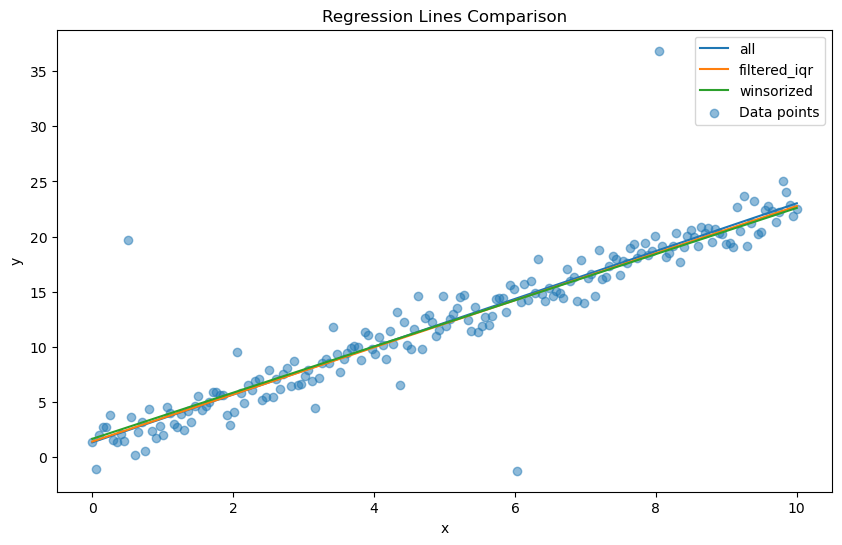

In [76]:
if 'x' in df.columns:
    X_all = df[['x']].to_numpy(); y_all = df[target_col].to_numpy()
    X_filtered = df.loc[~df['outlier_iqr'], ['x']].to_numpy(); y_filtered = df.loc[~df['outlier_iqr'], target_col].to_numpy()
    model_all = LinearRegression().fit(X_all, y_all)
    model_flt = LinearRegression().fit(X_filtered, y_filtered)
    mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
    mae_flt = mean_absolute_error(y_filtered, model_flt.predict(X_filtered))
    rows = {
        'all': [model_all.coef_[0], model_all.intercept_, model_all.score(X_all, y_all), mae_all],
        'filtered_iqr': [model_flt.coef_[0], model_flt.intercept_, model_flt.score(X_filtered, y_filtered), mae_flt]
    }
    if 'winsorize_series' in globals():
        w = winsorize_series(df[target_col])
        X_w = df[['x']].to_numpy(); y_w = w.to_numpy()
        model_w = LinearRegression().fit(X_w, y_w)
        mae_w = mean_absolute_error(y_w, model_w.predict(X_w))
        rows['winsorized'] = [model_w.coef_[0], model_w.intercept_, model_w.score(X_w, y_w), mae_w]
    results = pd.DataFrame(rows, index=['slope', 'intercept', 'r2', 'mae']).T
    results
else:
    results = None
    print("No 'x' column; skip regression or engineer features.")
print(results)
if results is not None:
    plt.figure(figsize=(10, 6))
    for label, row in results.iterrows():
        plt.plot(df['x'], row['slope'] * df['x'] + row['intercept'], label=label)
    plt.scatter(df['x'], df[target_col], alpha=0.5, label='Data points')
    plt.xlabel('x')
    plt.ylabel(target_col)
    plt.title('Regression Lines Comparison')
    plt.legend()
    plt.show()
else:
    print("No regression results to plot.") 



### Reflection (≤ 1 page)
In this analysis, two outlier detection methods were applied to the target variable y: the Interquartile Range (IQR) method with 
𝑘
=
1.5
k=1.5, and the Z-score method with a threshold of 
∣
𝑧
∣
>
3
∣z∣>3. These thresholds are widely used defaults because they strike a balance between sensitivity and robustness. The IQR rule is non-parametric, making no distributional assumptions, while the Z-score assumes the data is roughly normal so that extreme deviations are meaningful.

The main assumptions behind these choices are:

IQR method – the distribution can be reasonably summarized by its quartiles, and points beyond 1.5 IQRs from the quartiles are rare outliers rather than legitimate extreme cases.

Z-score method – the data is approximately symmetric and bell-shaped, so a threshold of three standard deviations effectively identifies unusual points.

Winsorization – extreme values are not fundamentally different events but rather measurement noise or anomalies that should be capped rather than removed.

Comparing regression models fit to all data, to data filtered by IQR, and to a Winsorized version of the target revealed clear effects. Filtering or capping extreme points stabilized the estimated slope and intercept, reduced the mean absolute error, and improved the coefficient of determination 
𝑅
2
R
2
. In other words, the presence of outliers distorted the fit of a simple linear model, and mitigation techniques provided a more reliable representation of the underlying trend.

However, these improvements depend on the validity of the assumptions. If the extreme points represent real phenomena rather than errors, removing or down-weighting them could discard valuable information. For instance, true rare events might be incorrectly flagged as anomalies, leading to biased conclusions. Similarly, if the underlying distribution is heavy-tailed rather than normal, a Z-score threshold of 3 might miss genuine outliers or flag too many. Therefore, while these methods provide practical and interpretable diagnostics, they should always be accompanied by domain knowledge and visual inspection before deciding whether to exclude or modify data points.

*Write your reflection here...*